In [11]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [20]:
def preprocess_image(image):
  image = preprocess_input(image) # resnet50-imagenet preprocessing protocol
  image = cv2.resize(image, (224, 224))
  image = np.expand_dims(image, axis=0) # add batch dimension
  image = tf.convert_to_tensor(image)
  return image

In [21]:
image = cv2.imread('/content/original.jpg')
preprocessedImage = preprocess_image(image)

In [4]:
model = ResNet50(weights="imagenet")

predictions = model.predict(preprocessedImage)
predictions = decode_predictions(predictions, top=3)[0] # parse the top-3 predictions

49152/35363 [=========================================] - 0s 0us/step


In [5]:
predictions

[('n03272010', 'electric_guitar', 0.9094282),
 ('n03124043', 'cowboy_boot', 0.014966248),
 ('n03929660', 'pick', 0.012409645)]

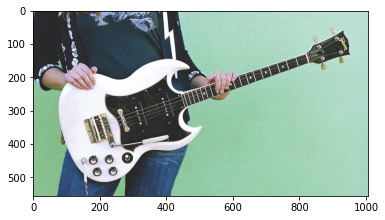

In [7]:
image_arr = np.asarray(image)
plt.imshow(cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


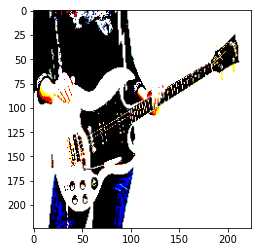

In [10]:
plt.imshow(np.squeeze(preprocessedImage))

ImageNet index for 'electric_guitar' : 546

# FGSM with Tensorflow

L-BFGS Attack used an expensive linear search method
to find the optimal value, which was time-consuming and
impractical. Goodfellow et al. proposed a fast method called
Fast Gradient Sign Method to generate adversarial examples [69]. They only performed one step gradient update along
the direction of the sign of gradient at each pixel. Their
perturbation can be expressed as: <br> 
<center> η = $\epsilon$sign(∇xJ(θ, x, l)) </center>
where $\epsilon$ is the magnitude of the perturbation. The generated
adversarial example x
is calculated as: x = x + η. This
perturbation can be computed by using back-propagation. <br>
<i>Yuan et al., Adversarial Examples: Attacks and Defenses for Deep Learning</i>

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [13]:
loss_obj = CategoricalCrossentropy()

In [25]:
def gen_adv(preprocessedImage, base_label):
  with tf.GradientTape() as tape:
    tape.watch(preprocessedImage)
    preds = model(preprocessedImage)
    
    loss = loss_obj(base_label, preds)
    gradient = tape.gradient(loss, preprocessedImage)
    
    signed_grad = tf.sign(gradient) # sign(grad_x(loss(x,l)))
    return signed_grad

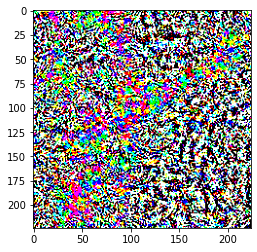

In [26]:
index = 546
image_probs = model.predict(preprocessedImage)

label = tf.one_hot(index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = gen_adv(preprocessedImage, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [27]:
eps = .01
adv_x = preprocessedImage + eps * perturbations
adv_x = tf.clip_by_value(adv_x, -1, 1)

preds_adv = model.predict(adv_x)
decode_predictions(preds_adv, top=3)

[[('n04286575', 'spotlight', 0.040829796),
  ('n03729826', 'matchstick', 0.03376388),
  ('n04548280', 'wall_clock', 0.02594383)]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


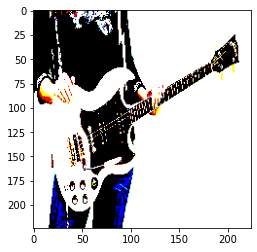

In [29]:
plt.imshow(np.squeeze(adv_x))

Another proposed method is Fast Gradient Value, in which the sign of the gradient is replaced with the raw gradient:
<center> η = ∇xJ(θ, x, l) </center> <br> This can generate adv_x with larger local difference to x.

# FGS 

In [38]:
def fgs(image, label):
  with tf.GradientTape() as tape:
    tape.watch(image)
    preds = model(image)
    loss = loss_obj(label, preds)
    gradient = tape.gradient(loss, image)
    eta = gradient
    return eta

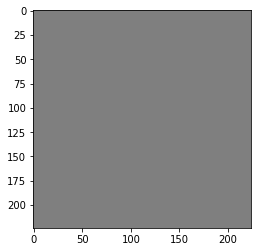

In [43]:
perturbation_fgs = fgs(preprocessedImage, label)
plt.imshow(np.squeeze(perturbation_fgs) * 0.5 + 0.5);

In [40]:
adv_fgs = preprocessedImage + eps * perturbation_fgs
adv_fgs = tf.clip_by_value(adv_fgs, -1, 1)

preds_fgs = model.predict(adv_fgs)
decode_predictions(preds_fgs, top=3)

[[('n04286575', 'spotlight', 0.040829927),
  ('n03729826', 'matchstick', 0.033769175),
  ('n04548280', 'wall_clock', 0.02594218)]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


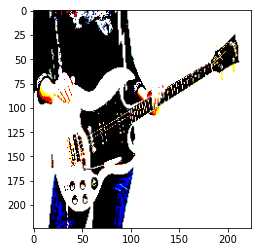

In [41]:
plt.imshow(np.squeeze(adv_fgs))